## Load the data + Train Cebra

### Setting up the environment

In [1]:
# install dependencies
#!pip install --pre --user cebra[datasets,demos]
import os
import sys
from pathlib import Path
notebook_to_core_path = Path(os.getcwd()).parent.parent.joinpath("core")
notebook_to_utils_path = Path(os.getcwd()).parent.parent.joinpath("utils")
sys.path.append(str(notebook_to_core_path))
sys.path.append(str(notebook_to_utils_path))

testfigdir = str(Path.cwd().joinpath("logs"))
run_all = False

from Visualizer import *
import torch
print(f"Cuda activated: {torch.cuda.is_available()}")

import matplotlib.pyplot as plt
plt.style.use('dark_background')

%matplotlib inline
#%matplotlib tk
%autosave 180
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

c:\Users\mauls\miniconda3\envs\neo_cebra\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cuda activated: True


c:\Users\mauls\miniconda3\envs\neo_cebra\lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Autosaving every 180 seconds


In [37]:
# settings paths
root_dir = "D:\\Experiments"
experimentalist = "Renan"
paradigm = "VR"
animal_root_dir = os.path.join(root_dir, experimentalist, paradigm)

# setting data to use
behavior_datas = [
    "position",
    "distance",
    "velocity",
    "moving",
]  # , "acceleration", "stimulus"]
wanted_animal_ids = ["all"]
wanted_dates = ["all"]
load_all = False
animal_id = "DON-000000"
sessions = ["20250318"]
regenerate_plots = True
# regenerate_behavior_data=True

# cebra setting
regenerate = False
manifolds_pipeline = "cebra"
# quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000
model_settings = {
    "place_cell": {"method": "skaggs"},
    "cebra": {"max_iterations": 5000, "output_dimension": 3},
}

### Load Data

No raw data given. Regeneration not possible. Loading old data.
Loading D:\Experiments\Renan\VR\DON-000000\20250318\1-no-VR\002P-F\tif\suite2p\plane0\DON-000000_20250318_1-no-VR_photon.npy
No raw data given. Regeneration not possible. Loading old data.
Loading D:\Experiments\Renan\VR\DON-000000\20250318\1-no-VR\TRD-2P\DON-000000_20250318_1-no-VR_position.npy
Generating data based on raw_data_object for distance in D:\Experiments\Renan\VR\DON-000000\20250318\1-no-VR\TRD-2P\DON-000000_20250318_1-no-VR_distance.npy.
Creating distance dataset based on raw data from position.
Generating data based on raw_data_object for velocity in D:\Experiments\Renan\VR\DON-000000\20250318\1-no-VR\TRD-2P\DON-000000_20250318_1-no-VR_velocity.npy.
Creating velocity dataset based on raw data from distance.
Calculating smooth velocity based on butter_lowpass_filter 2Hz, 30fps, 2nd order.
Generating data based on raw_data_object for moving in D:\Experiments\Renan\VR\DON-000000\20250318\1-no-VR\TRD-2P\DON-00000

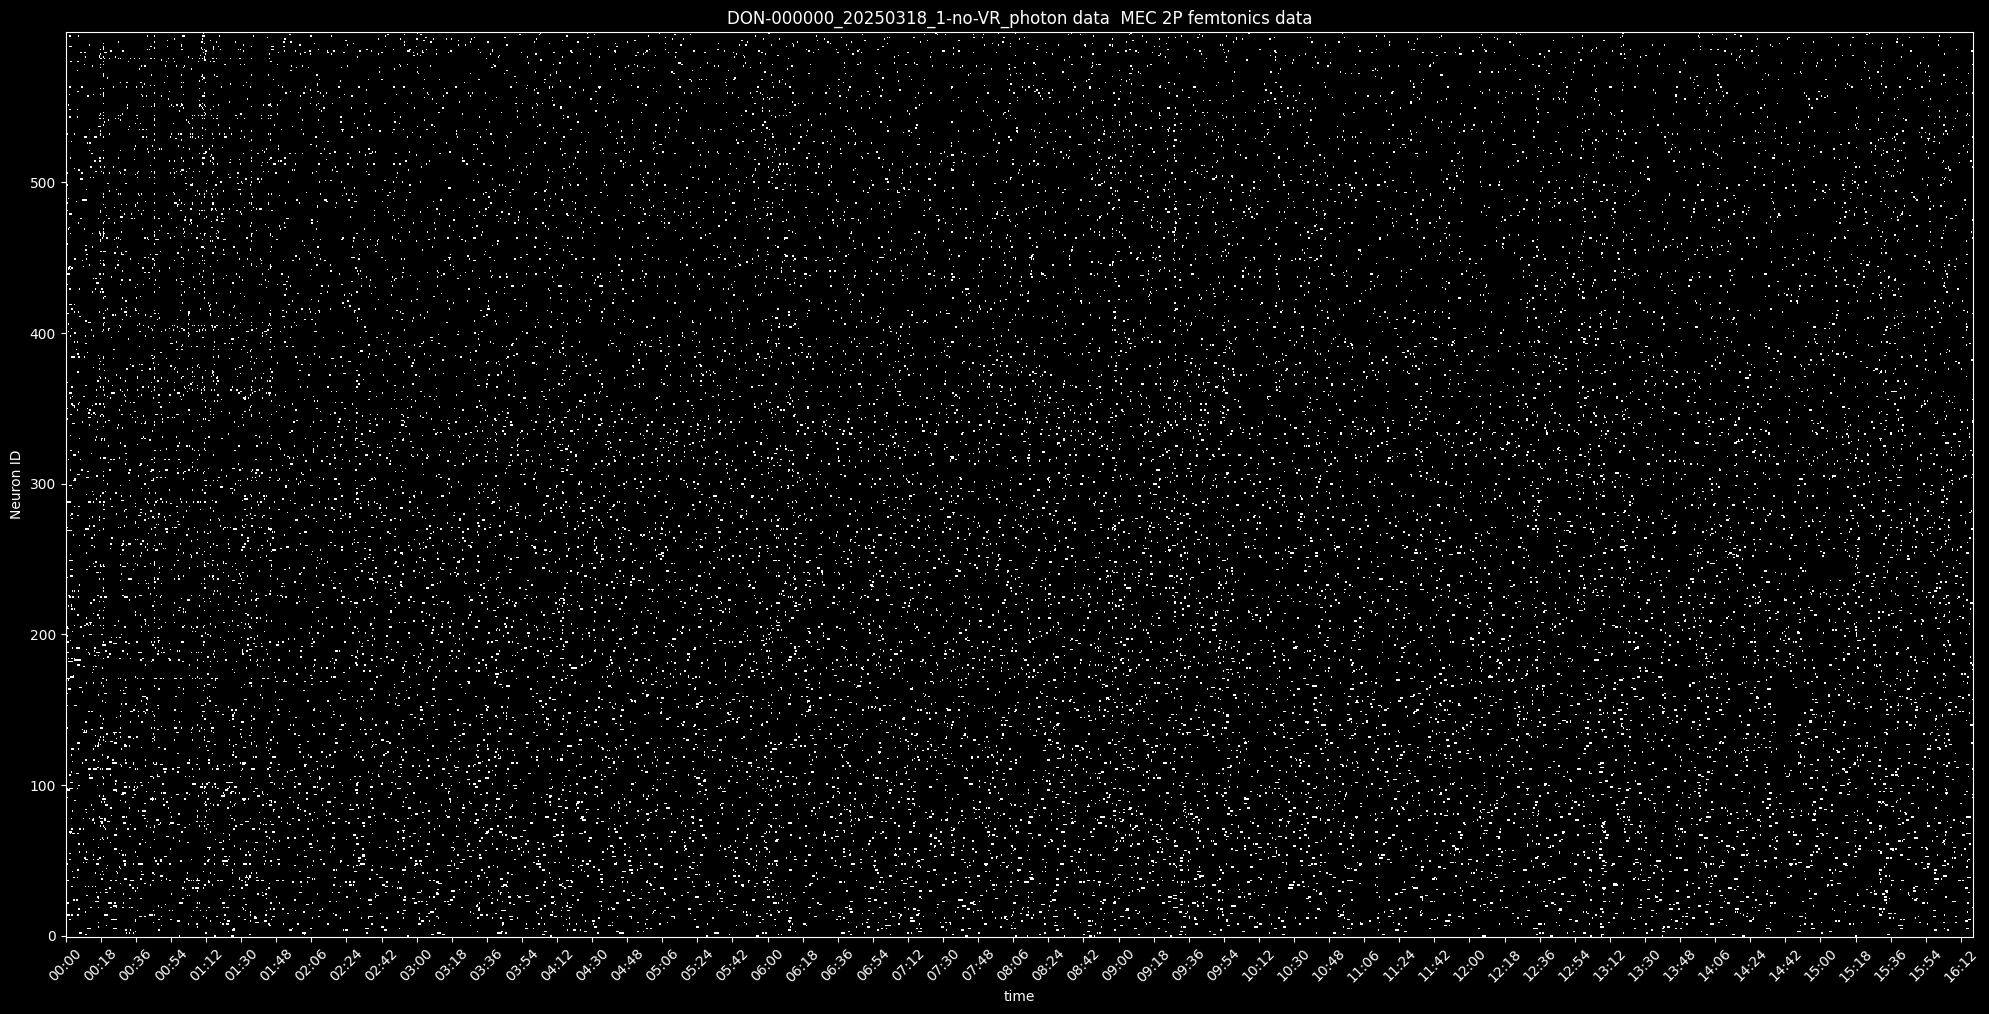

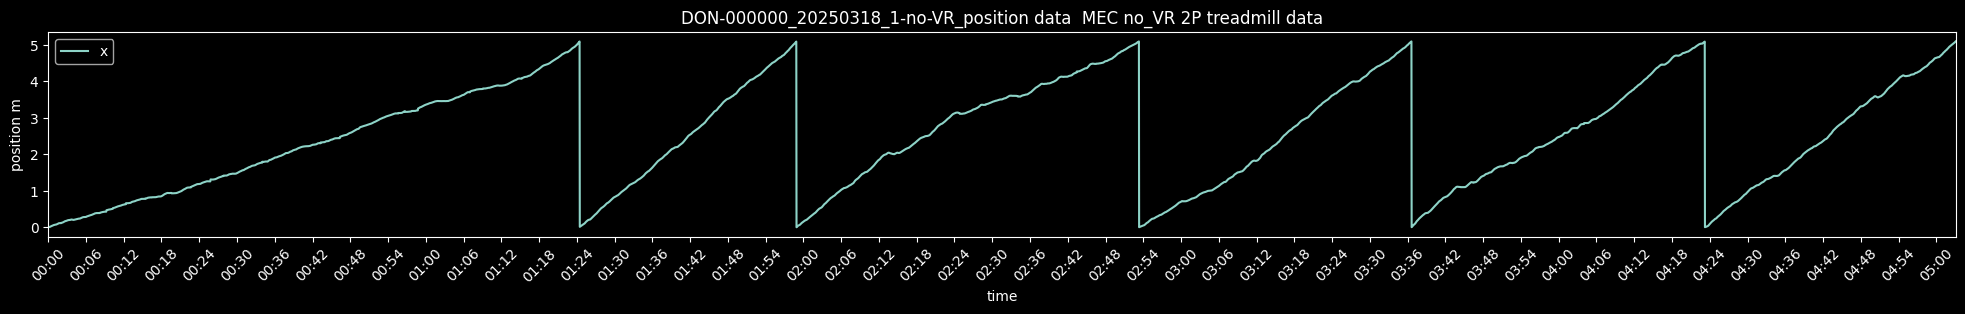

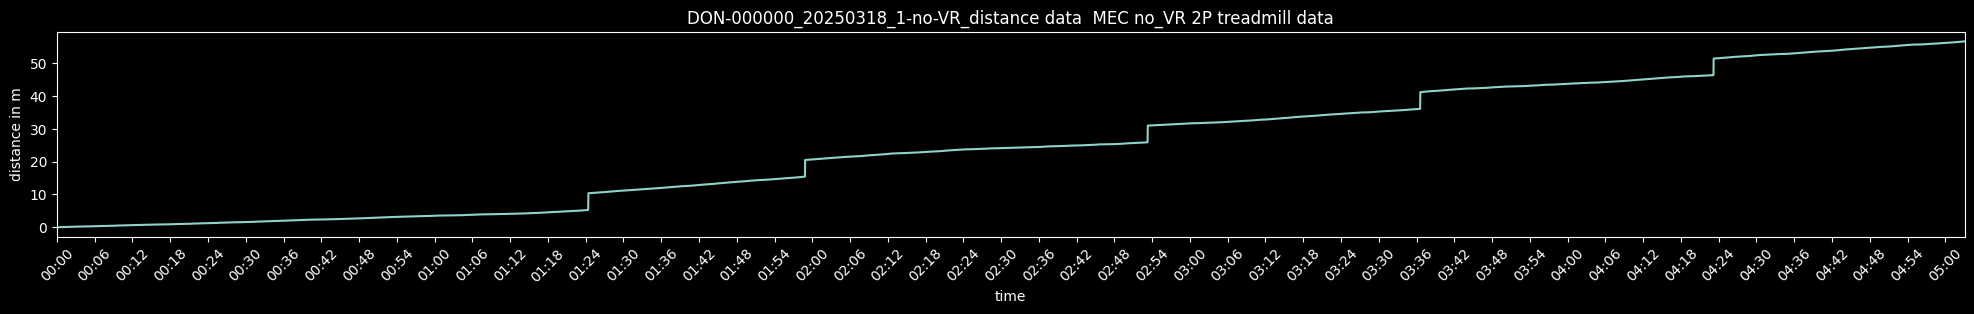

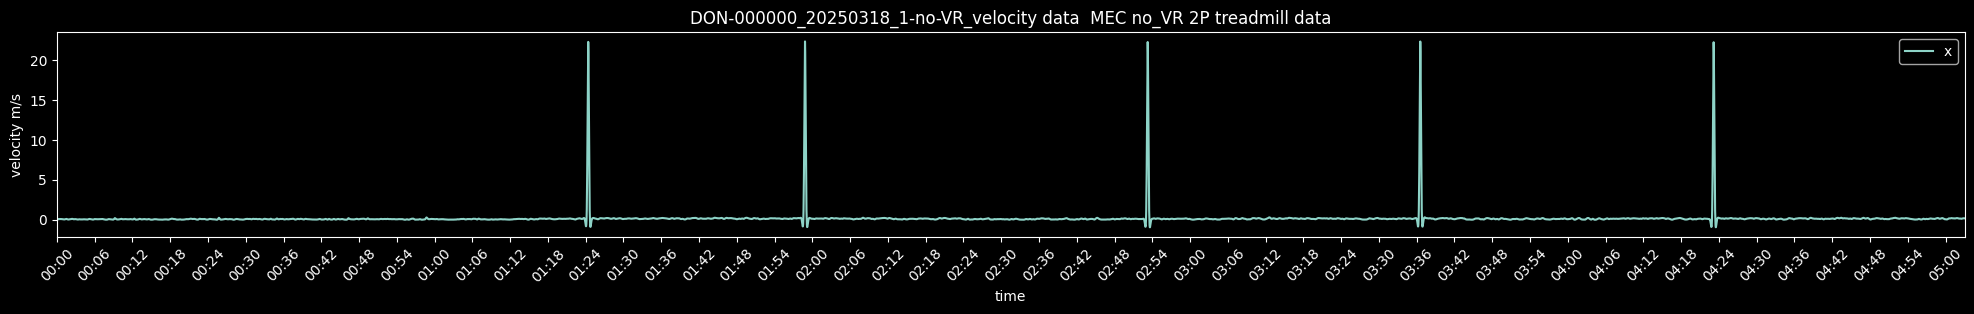

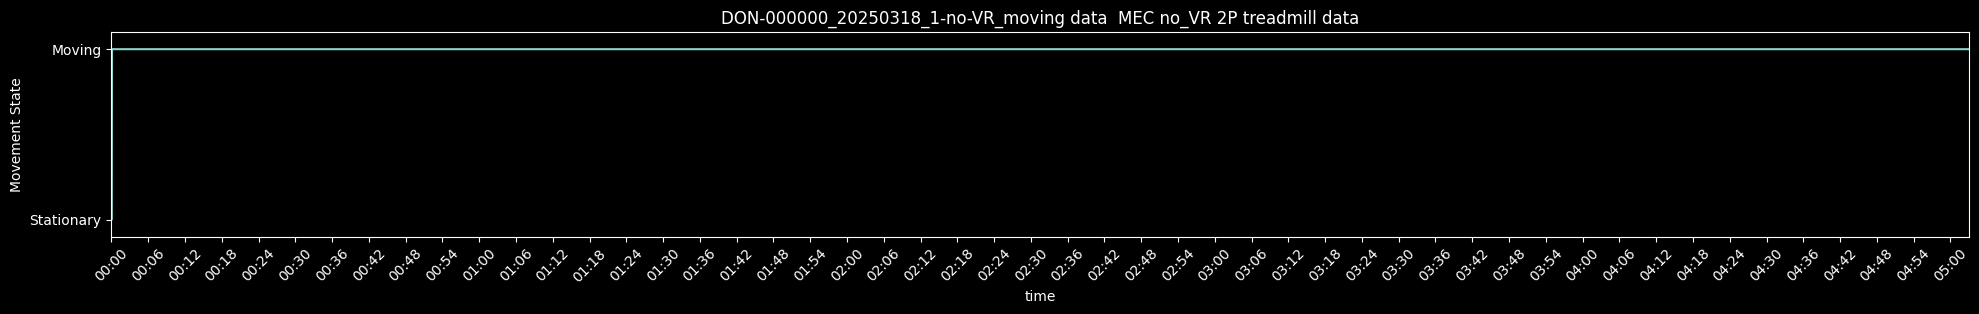

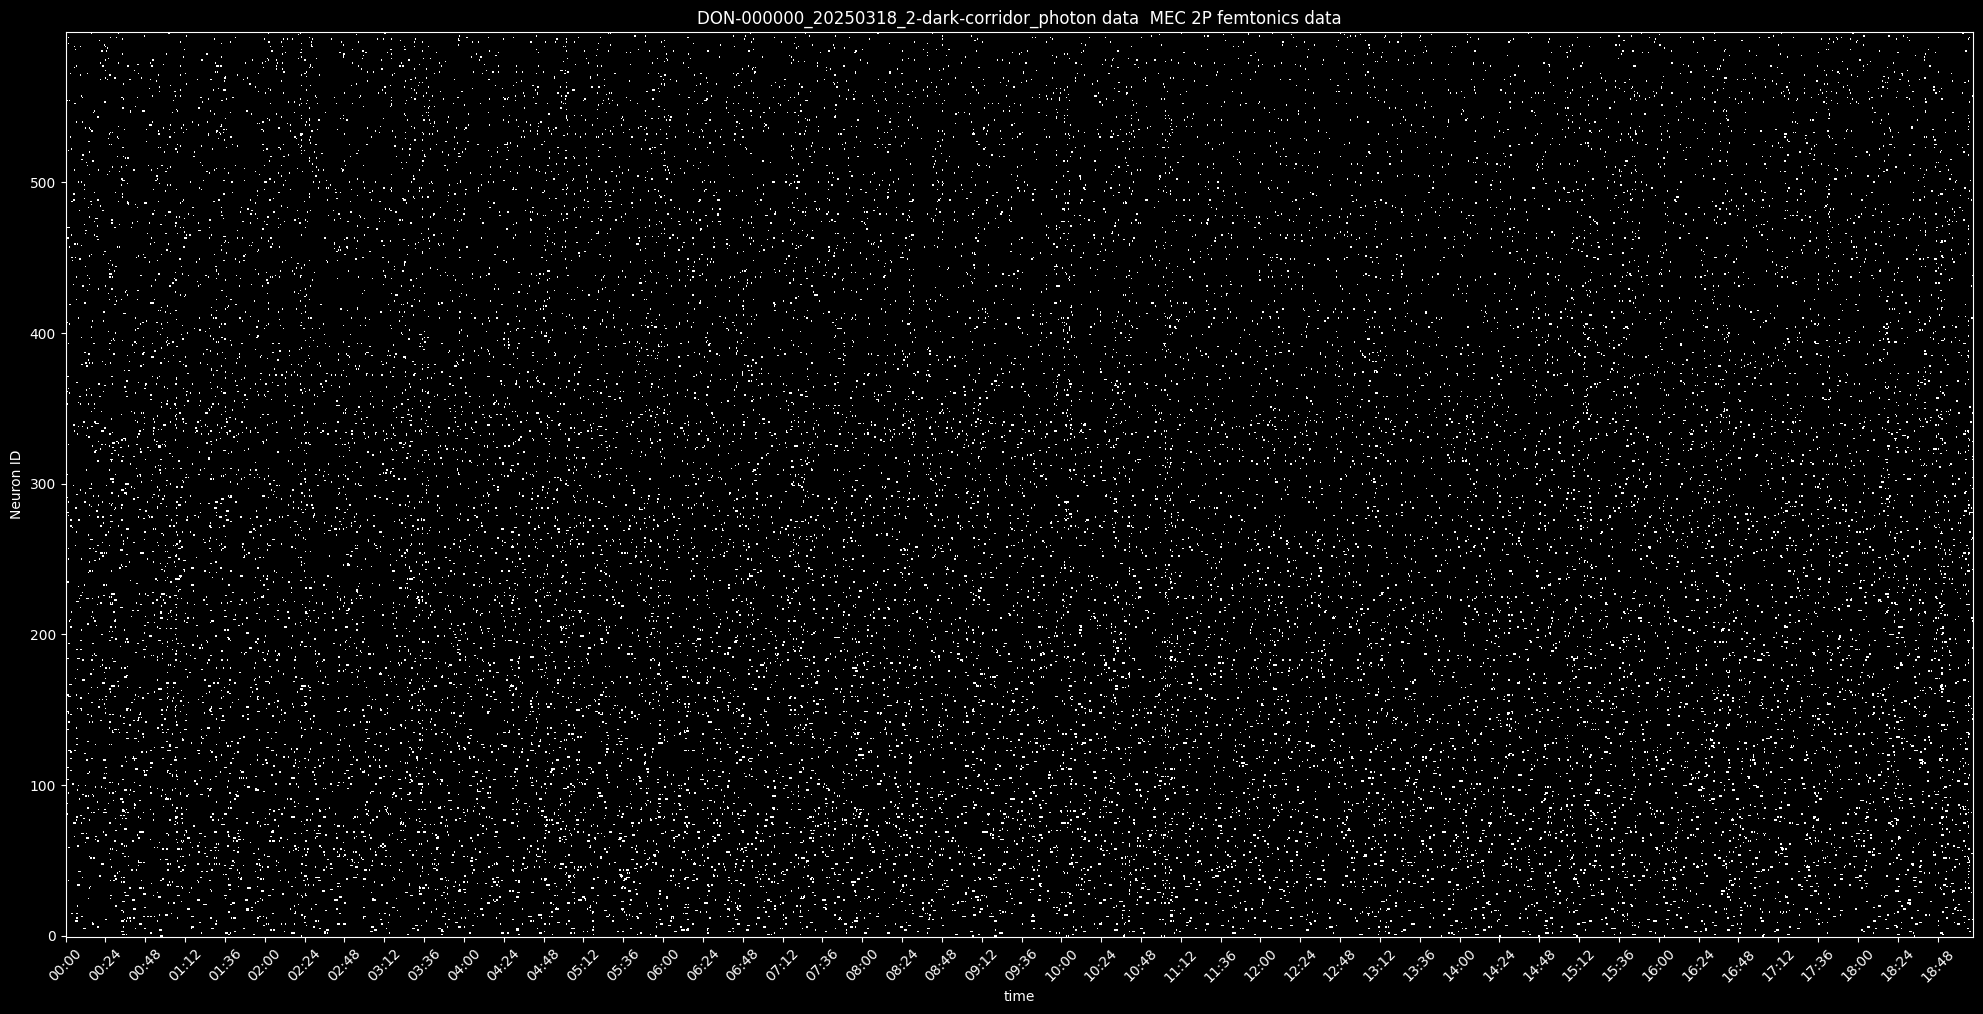

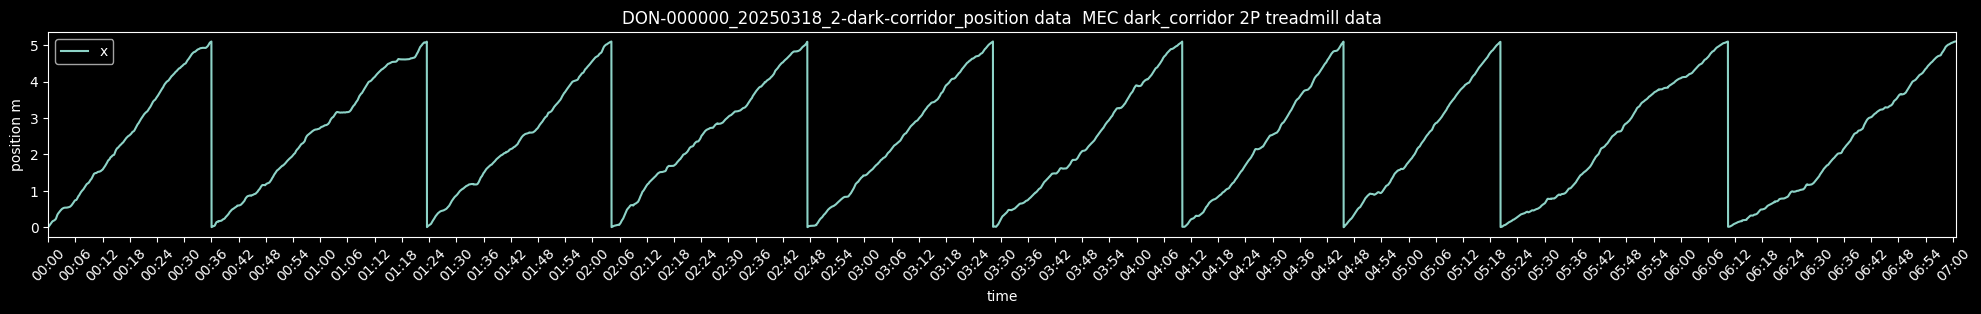

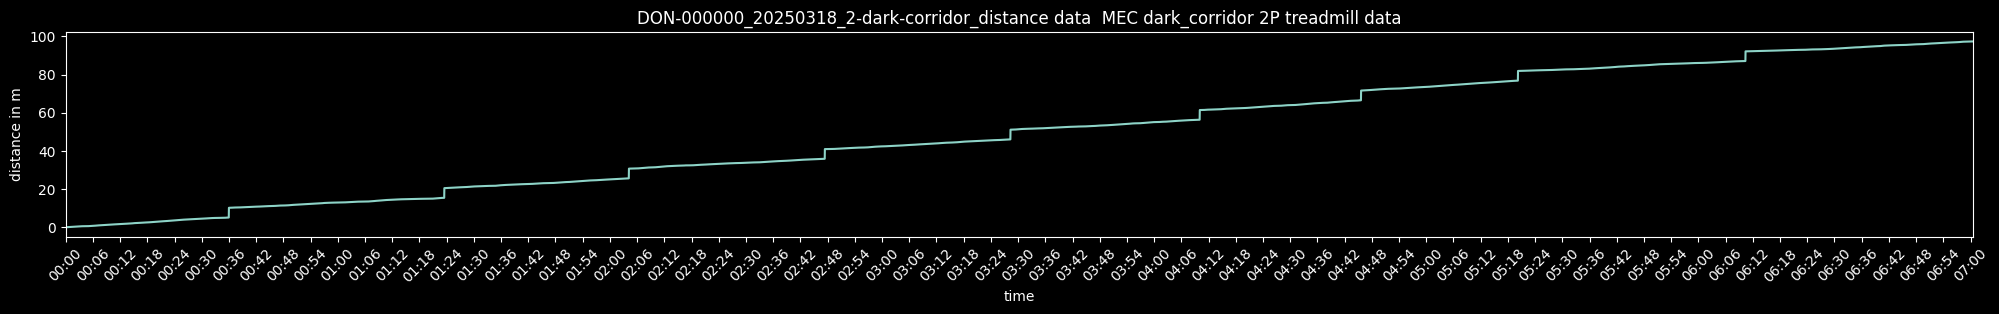

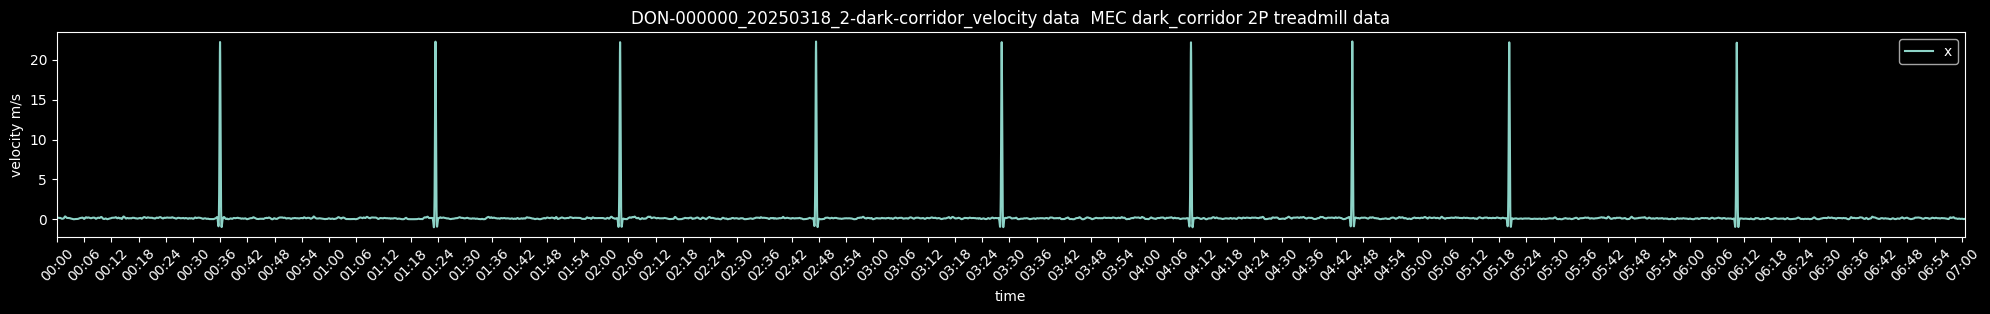

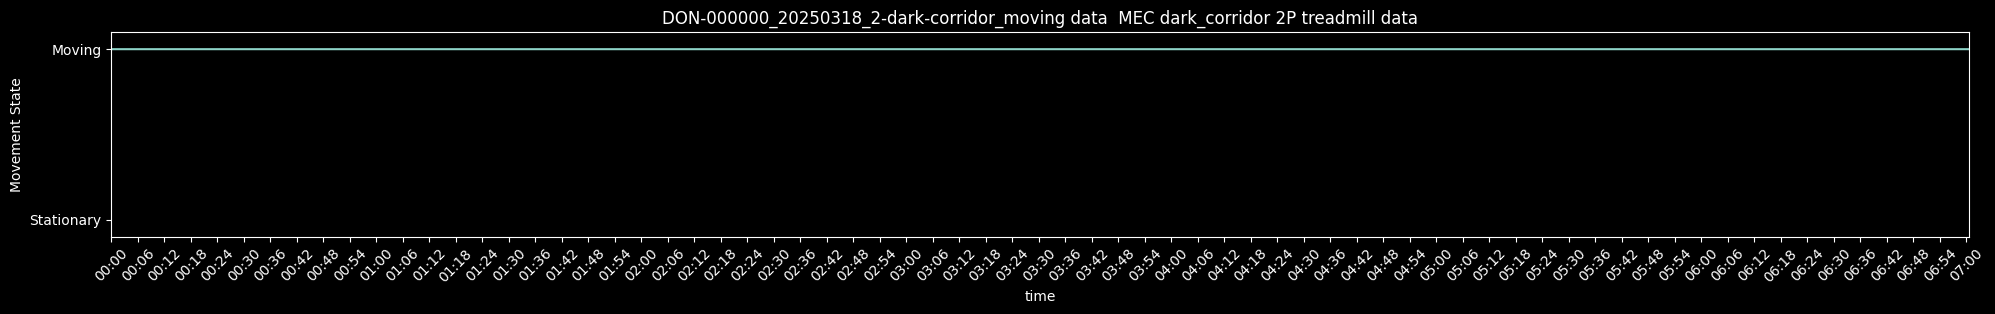

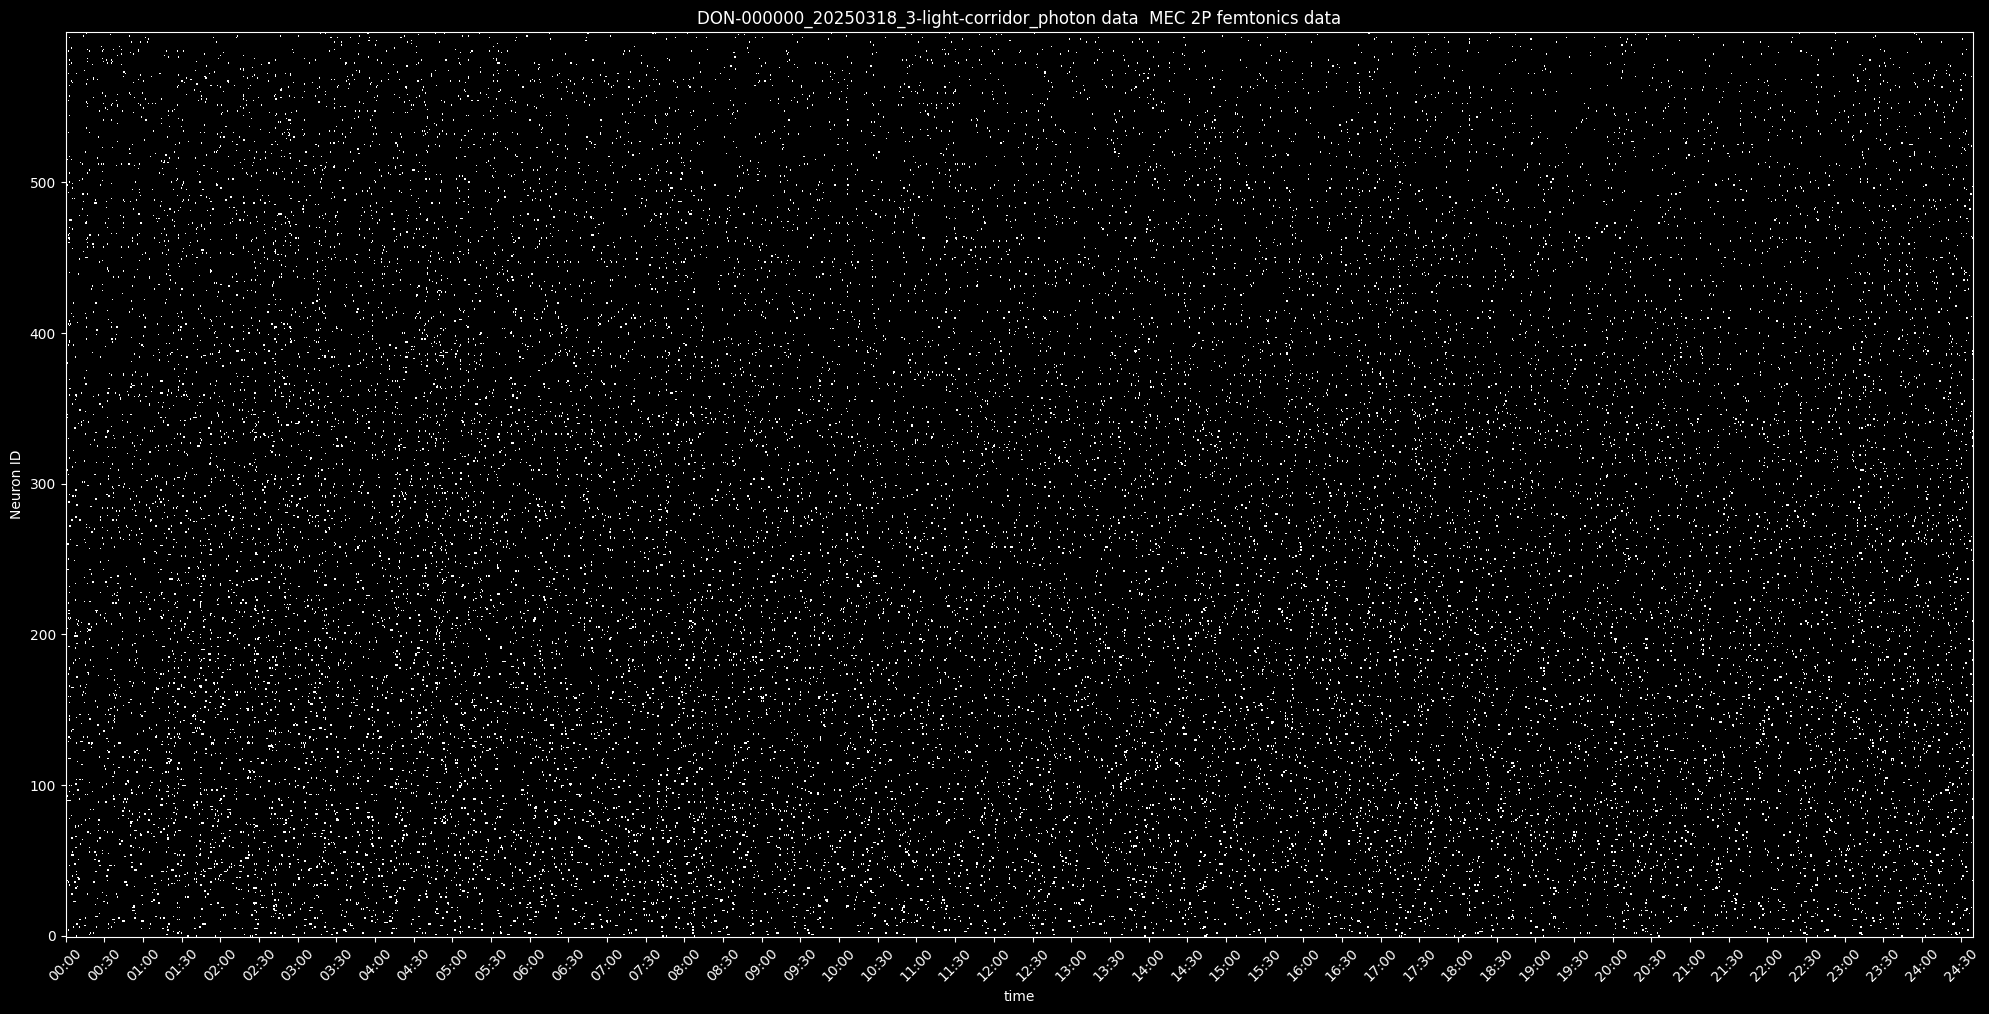

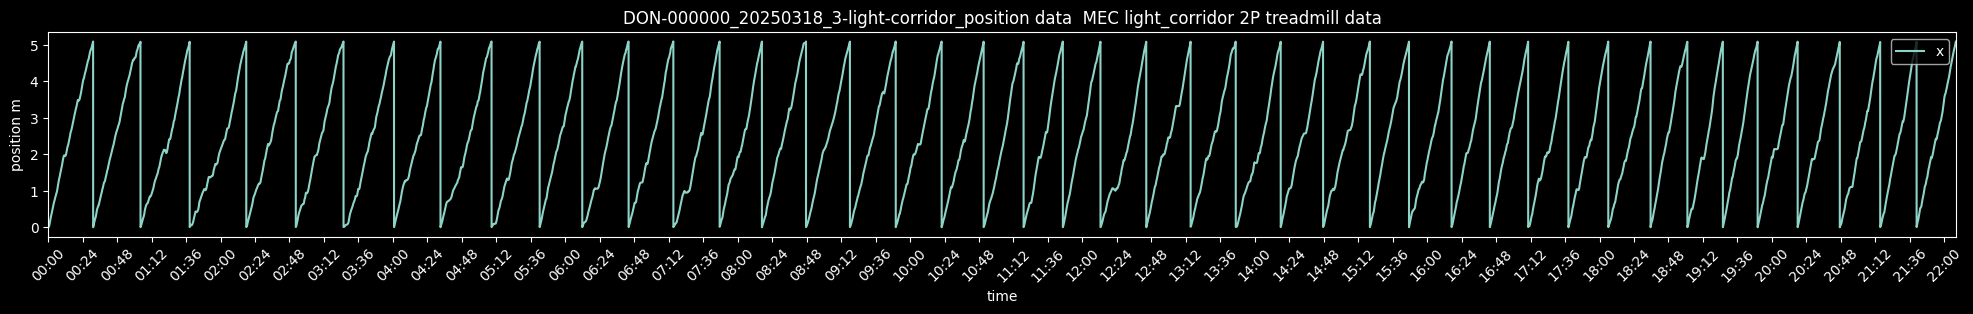

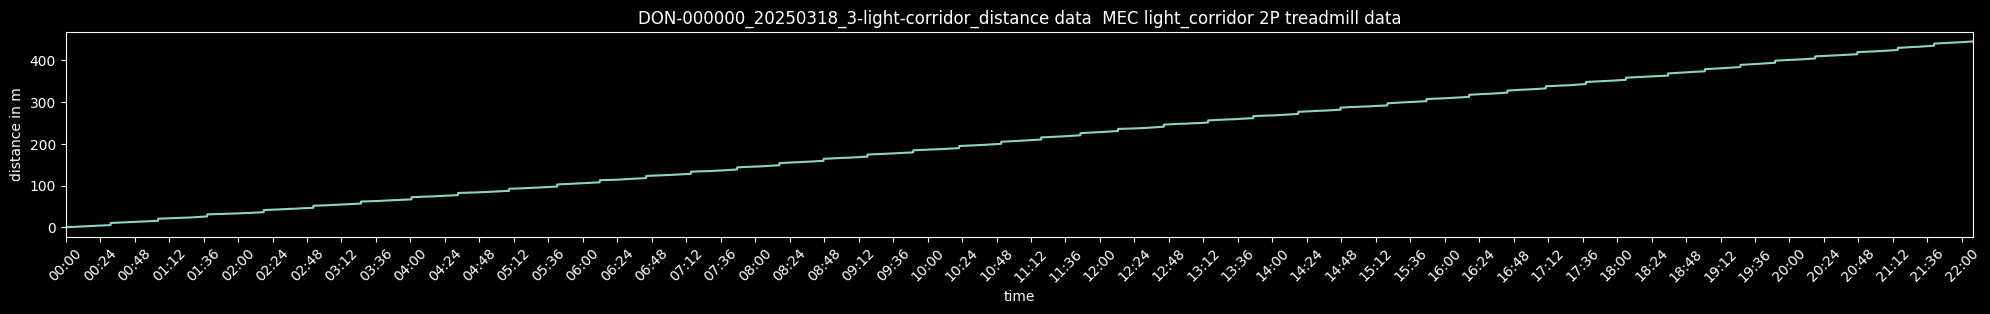

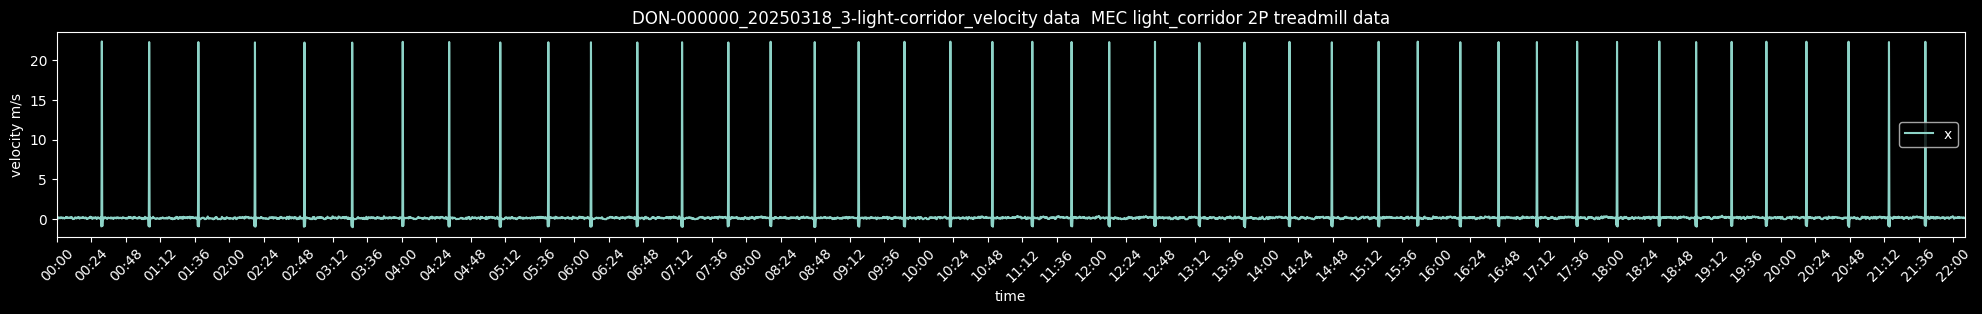

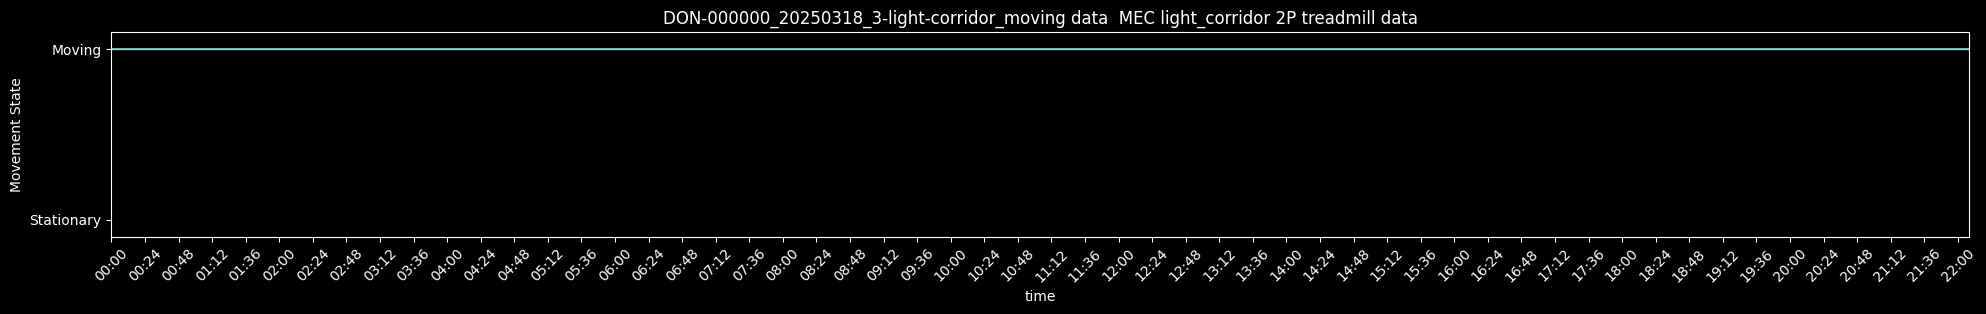

In [55]:
# initialize session
from Classes import Animal, Session

run = True
regenerate = False
regenerate_plots = False
load_all = False
while run:
    if load_all:
        animals = load_all_animals(
            animal_root_dir,
            wanted_animal_ids=wanted_animal_ids,
            wanted_dates=wanted_dates,
            model_settings=model_settings,  # ) dont load data
            behavior_datas=behavior_datas,
            regenerate=regenerate,
            regenerate_plots=regenerate_plots,
        )  # Load neural, behavior, data for all session parts.

        # load_data manually
        # for animal_id, animal in animals.items():
        #    animal.load_all_data(behavior_datas=behavior_datas)
        #    for session_date, session in animal.sessions.items():
        #        session.load_all_data(behavior_datas=behavior_datas)
    else:
        animal = Animal(animal_id, root_dir=animal_root_dir)
        for session_date in sessions:
            animal.add_session(
                date=session_date,
                model_settings=model_settings,
                behavior_data=behavior_datas,
            )  # Load neural, behavior, data for all session parts.
        for session_date, session in animal.sessions.items():
            # session.add_tasks(task_name_list=["R1", "R2", "R3"])
            session.add_tasks()  # tasks=["S1", "S2", "S3"])
            # session.add_task("S2", metadata=session.tasks_infos["S2"])
            # Load neural, behavior, data for all session parts.
            data = session.load_all_data(
                behavior_datas=behavior_datas,
                regenerate=regenerate,
                regenerate_plots=regenerate_plots,
            )

        animals = {animal.id: animal}
        session = animal.sessions[session_date]
        
    ############################# This is only for renan's data since the position is in cm not meters #############################
    for animal_id, animal in animals.items():
        for session_date, session in animal.sessions.items():
            for task_name, task in session.tasks.items():
                # Check if any number is above 6
                if np.any(task.behavior.position.data > 6):
                    print(
                        "There is at least one number above 6 in the array. Correcting... cm/s to m/s"
                    )
                    corrected_position = task.behavior.position.data / 100
                    print(f"Overriding previouse position data with corrected data")
                    np.save(task.behavior.position.path, corrected_position)
                    print(
                        f"Updating {task.id} task.behavior.position.data with corrected data"
                    )
                    task.behavior.position.data = corrected_position
                    # set pipeline to rerun and regenerate files and plots
                    run = True
                    regenerate = True
                    regenerate_plots = True
                else:
                    run = False
                    regenerate = False    

### Train Models on all data

In [56]:
# Train the model
# Loading time and position models
behavior_data_types = ["position"]  # , "moving", "stimulus"]
movement_states = ["moving"]
regenerate = False

for animal_id, animal in animals.items():
    for session_date, session in animal.sessions.items():
        for task_name, task in session.tasks.items():
            for movement_state in movement_states:
                cebra_behavior_model = task.train_model(
                    model_type="behavior",
                    model_name="position",
                    regenerate=regenerate,
                    movement_state=movement_state,
                    # behavior_data_types=["position", "stimulus"], #behavior_data_types, #auxilarry variables
                    behavior_data_types=behavior_data_types,  # behavior_data_types, #auxilarry variables
                    manifolds_pipeline=manifolds_pipeline,
                    model_settings=model_settings,
                    transformation="relative",
                )

                # for decoder
                cebra_behavior_model = task.train_model(
                    model_type="behavior",
                    model_name="position",
                    regenerate=regenerate,
                    movement_state=movement_state,
                    # behavior_data_types=["position", "stimulus"], #behavior_data_types, #auxilarry variables
                    behavior_data_types=behavior_data_types,  # behavior_data_types, #auxilarry variables
                    manifolds_pipeline=manifolds_pipeline,
                    model_settings=model_settings,
                    transformation="relative",
                    split_ratio=0.8,
                )

DON-000000_20250318_1-no-VR
Loaded matching model D:\Experiments\Renan\VR\DON-000000\20250318\models\cebra_behavior_position_moving_relative_iter-5000_dim-3_model-1-no-VR.pt
Training  behavior_position_moving_relative_iter-5000 model.


pos: -0.9833 neg:  6.3999 total:  5.4167 temperature:  1.0000: 100%|██████████| 5000/5000 [00:28<00:00, 172.43it/s]


DON-000000_20250318_1-no-VR
Loaded matching model D:\Experiments\Renan\VR\DON-000000\20250318\models\cebra_behavior_position_moving_0.8_relative_iter-5000_dim-3_model-1-no-VR.pt
Training  behavior_position_moving_0.8_relative_iter-5000 model.


pos: -0.9909 neg:  6.4021 total:  5.4112 temperature:  1.0000: 100%|██████████| 5000/5000 [00:27<00:00, 178.63it/s]


DON-000000_20250318_2-dark-corridor
Loaded matching model D:\Experiments\Renan\VR\DON-000000\20250318\models\cebra_behavior_position_moving_relative_iter-5000_dim-3_model-2-dark-corridor.pt
Training  behavior_position_moving_relative_iter-5000 model.


pos: -0.9800 neg:  6.3997 total:  5.4197 temperature:  1.0000: 100%|██████████| 5000/5000 [00:29<00:00, 170.95it/s]


DON-000000_20250318_2-dark-corridor
Loaded matching model D:\Experiments\Renan\VR\DON-000000\20250318\models\cebra_behavior_position_moving_0.8_relative_iter-5000_dim-3_model-2-dark-corridor.pt
Training  behavior_position_moving_0.8_relative_iter-5000 model.


pos: -0.9800 neg:  6.4000 total:  5.4200 temperature:  1.0000: 100%|██████████| 5000/5000 [00:28<00:00, 177.60it/s]


DON-000000_20250318_3-light-corridor
Loaded matching model D:\Experiments\Renan\VR\DON-000000\20250318\models\cebra_behavior_position_moving_relative_iter-5000_dim-3_model-3-light-corridor.pt
Training  behavior_position_moving_relative_iter-5000 model.


pos: -0.9555 neg:  6.4009 total:  5.4454 temperature:  1.0000: 100%|██████████| 5000/5000 [00:38<00:00, 130.69it/s]


DON-000000_20250318_3-light-corridor
Loaded matching model D:\Experiments\Renan\VR\DON-000000\20250318\models\cebra_behavior_position_moving_0.8_relative_iter-5000_dim-3_model-3-light-corridor.pt
Training  behavior_position_moving_0.8_relative_iter-5000 model.


pos: -0.9593 neg:  6.4027 total:  5.4434 temperature:  1.0000: 100%|██████████| 5000/5000 [00:35<00:00, 142.10it/s]


### Plot 3D Embeddings, Losses

In [ ]:
# for animal_id, animal in animals.items():
#     for session_date, session in animal.sessions.items():
#         for task_name, task in session.tasks.items():
#             task.plot_embeddings(model_naming_filter_exclude="0.")
#             task.plot_model_losses(model_naming_filter_exclude="0.")

File D:\Experiments\Renan\VR\DON-000000\20250318\1-no-VR\002P-F\tif\suite2p\plane0\[A-Za-z0-9 ()_-]*binarized_traces[A-Za-z0-9 ()_-]*.npz not found, returning None
File D:\Experiments\Renan\VR\DON-000000\20250318\2-dark-corridor\002P-F\tif\suite2p\plane0\[A-Za-z0-9 ()_-]*binarized_traces[A-Za-z0-9 ()_-]*.npz not found, returning None
File D:\Experiments\Renan\VR\DON-000000\20250318\3-light-corridor\002P-F\tif\suite2p\plane0\[A-Za-z0-9 ()_-]*binarized_traces[A-Za-z0-9 ()_-]*.npz not found, returning None


<Figure size 1500x400 with 0 Axes>

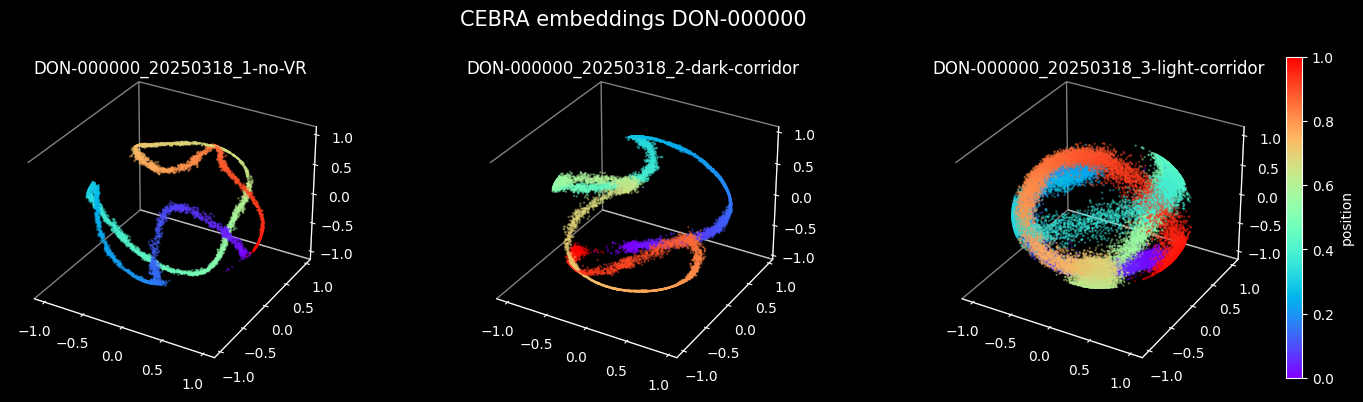

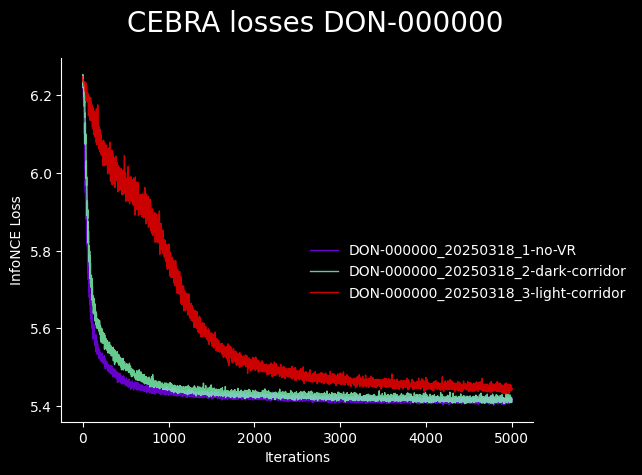

In [57]:
behavior_type = "position"
for animal_id, animal in animals.items():
    animal.plot_task_models(
        manifolds_pipeline=manifolds_pipeline,
        behavior_type=behavior_type,
        model_naming_filter_include=[behavior_type, "5000"],
        model_naming_filter_exclude="0.",
    )

### PCA needed for 80% variance

DON-000000_20250318_1-no-VR
behavior_position_moving_relative_iter-5000
(9088, 600)
DON-000000_20250318_2-dark-corridor
behavior_position_moving_relative_iter-5000
(12618, 600)
DON-000000_20250318_3-light-corridor
behavior_position_moving_relative_iter-5000
(39840, 600)


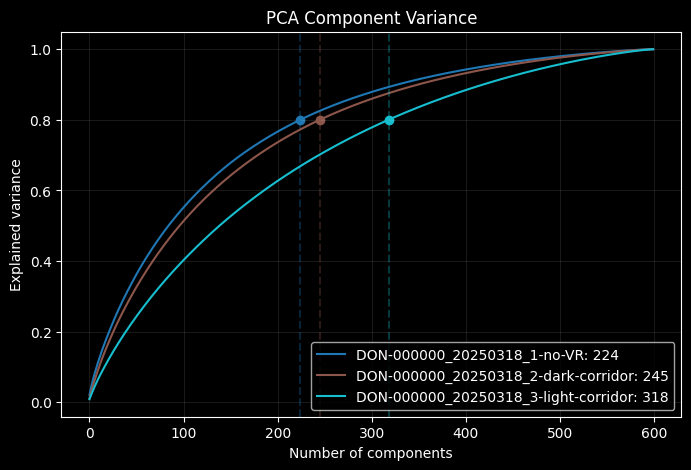

In [59]:
from Visualizer import pca_component_variance_plot
from sklearn.preprocessing import StandardScaler

for animal_id, animal in animals.items():
    for session_date, session in animal.sessions.items():
        task_neural_data = []
        labels = []
        for task_name, task in session.tasks.items():
            model_class, modellist = task.models.get_pipeline_models(
                manifolds_pipeline=manifolds_pipeline,
                model_naming_filter_include=["5000"],
                model_naming_filter_exclude="0.",
            )
            print(task.id)
            model = modellist[list(modellist.keys())[0]]
            print(model.name)
            neural = model.get_data(type="neural")
            print(neural.shape)
            task_neural_data.append(neural)
            labels.append(task.id)

        pca_component_variance_plot(task_neural_data, labels=labels)

### Decoding Performance

Processing: 100%|██████████| 3/3 [00:10<00:00,  3.52s/it]


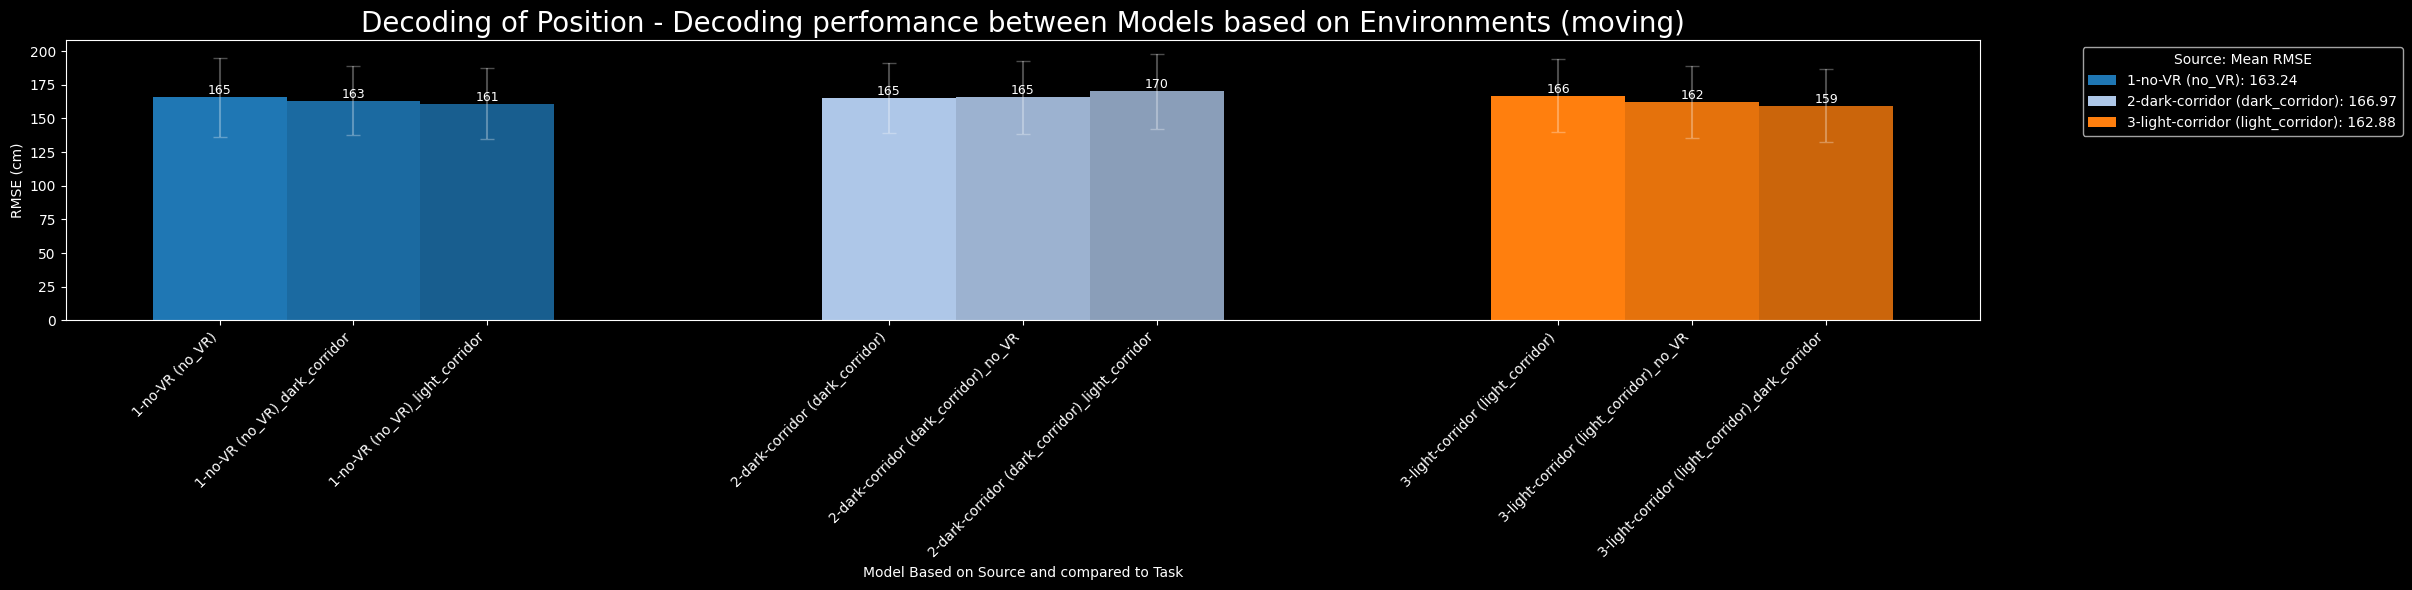

In [ ]:
# Cross Decoding results with absolute positions
model_cross_decoding = session.task_model_cross_decode(
    manifolds_pipeline="cebra",
    model_naming_filter_include=["5000", "0.8"],
    model_naming_filter_exclude=None,
)

### Structural Index - CURRENTLY NOT WORKING

In [ ]:
params = {
    "n_bins": 3,
    "n_neighbors": 15,
    "discrete_label": False,
    "num_shuffles": 0,
    "verbose": True,
}

for animal_id, animal in animals.items():
    for session_date, session in animal.sessions.items():
        for task_name, task in session.tasks.items():
            # model = task.random_model
            # embeddings = {model.name: model.data["train"]["neural"]}
            # embeddings = {model.name : model.data["train"]["embedding"]}
            # labels = {model.name: model.data["train"]["behavior"]}

            # task.plot_embeddings()
            structural_indices = task.structural_indices(
                # embeddings=embeddings,
                # labels=labels,
                params=params,
                model_naming_filter_include=["12800", "position"],
                model_naming_filter_exclude="0.",
                plot=True,
                regenerate=True,
                use_raw=True,
            )

#### Structural Index - Number Neighbors Sweep

In [ ]:
params = {
    "n_bins": 3,
    "n_neighbors": np.arange(3, 300, 5),
    "discrete_label": False,
    "num_shuffles": 0,
    "verbose": True,
}

for animal_id, animal in animals.items():
    for session_date, session in animal.sessions.items():
        for task_name, task in session.tasks.items():
            # model = task.random_model
            # embeddings = {model.name: model.data["train"]["neural"]}
            # embeddings = {model.name : model.data["train"]["embedding"]}
            # labels = {model.name: model.data["train"]["behavior"]}

            # task.plot_embeddings()
            structural_indices = task.structural_indices(
                # embeddings=embeddings,
                # labels=labels,
                params=params,
                model_naming_filter_include=["12800", "position"],
                model_naming_filter_exclude="0.",
                plot=True,
                regenerate=True,
                use_raw=True,
            )

### Shape Similarity - Not properly implemented yet